In [1]:
#import sys
#sys.path.append('/home/tidiane/dev/pasteur/palm-tools-master/src')

In [2]:
%load_ext autoreload
%autoreload 2
from palm_tools import TrackSets
from palm_tools.analysis import MMDInterUnitAnalysis, MDSAnalysis, MMDInterGroupAnalysis
from palm_tools.post_processing import Gratin, GratinParameters
from palm_tools.post_processing.ts_post_processing import PostProcessingStepSeries
import pandas as pd
import numpy as np
from glob import glob
import os
import shutil
import zarr
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
if "Users" in os.getcwd():
    ORIGINAL_TRACKS_FILES = glob("/home/tidiane/dev/pasteur/example_files/*.trxyt",recursive=True)
    EXPORT_FOLDER = "/home/tidiane/dev/pasteur/export_folder"
else:
    # Source files, they're left untouched, only read
    ORIGINAL_TRACKS_FILES = glob("/home/tidiane/dev/pasteur/example_files/*.trxyt",recursive=True)
    # We copy files in this directory, it's as if they were 'uploaded' there by the user
    EXPORT_FOLDER = "/home/tidiane/dev/pasteur/export_folder"

if not os.path.exists(EXPORT_FOLDER):
    os.mkdir(EXPORT_FOLDER)
TRACKS_FILES = []
for f in ORIGINAL_TRACKS_FILES:
    tf = os.path.join(EXPORT_FOLDER,os.path.split(f)[-1])
    shutil.copy(f,tf)
    TRACKS_FILES.append(tf)

In [4]:
TRACKS_FILES

['/home/tidiane/dev/pasteur/export_folder/02e0de7a4caebc82.trxyt',
 '/home/tidiane/dev/pasteur/export_folder/66e67e9052c35e8d.trxyt',
 '/home/tidiane/dev/pasteur/export_folder/10fd51e9edc4d570.trxyt',
 '/home/tidiane/dev/pasteur/export_folder/1d372d16b9d77091.trxyt']

In [5]:
index_df = pd.read_csv("/home/tidiane/dev/pasteur/export_folder/index.csv")
index_df.head()

file_name                                               file  \
0  1d372d16b9d77091.trxyt  /home/tidiane/dev/pasteur/export_folder/1d372d...   
1  10fd51e9edc4d570.trxyt  /home/tidiane/dev/pasteur/export_folder/10fd51...   
2  66e67e9052c35e8d.trxyt  /home/tidiane/dev/pasteur/export_folder/66e67e...   
3  02e0de7a4caebc82.trxyt  /home/tidiane/dev/pasteur/export_folder//02e0d...   

  include arbitrary_condition time  
0       Y                   A   t1  
1       Y                   B   t1  
2       Y                   A   t2  
3       Y                   B   t2

In [6]:
levels_dict = {}
group_idx = 0
for level_idx, level in enumerate(index_df) :
    if level not in ["file_name", "file", "include"]:
        lvl_dict = {}
        for group in index_df[level].unique():
            lvl_dict[group] = group_idx
            group_idx += 1
        levels_dict[level] = [level_idx,lvl_dict]

print(levels_dict)
print(list(levels_dict.keys()))
    

{'arbitrary_condition': [3, {'A': 0, 'B': 1}], 'time': [4, {'t1': 2, 't2': 3}]}
['arbitrary_condition', 'time']


In [7]:
import json
with open(EXPORT_FOLDER+"/levels_dict.json", "w") as outfile:
    json.dump(levels_dict, outfile)

# Création du TrackSets

In [8]:
tss = TrackSets.from_files(TRACKS_FILES,root_folder=EXPORT_FOLDER,index_df=index_df)

In [9]:
for ts in tss:
    print(ts)

Set of 693 trajs coming from file /home/tidiane/dev/pasteur/export_folder/02e0de7a4caebc82.trxyt
Set of 2529 trajs coming from file /home/tidiane/dev/pasteur/export_folder/66e67e9052c35e8d.trxyt
Set of 595 trajs coming from file /home/tidiane/dev/pasteur/export_folder/10fd51e9edc4d570.trxyt
Set of 1468 trajs coming from file /home/tidiane/dev/pasteur/export_folder/1d372d16b9d77091.trxyt


In [10]:
tss[0].locs.columns

Index(['x', 'y', 'frame', 'sigma', 't', 'n'], dtype='object')

# Embeddings avec Gratin

In [11]:
gratin_path = "/home/tidiane/dev/pasteur/models/demo2"
from gratin.standard import train_model
##train_model(export_path=gratin_path,time_delta=0.03,max_n_epochs=1)

2022-07-06 13:45:49.850034: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-06 13:45:49.850160: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [12]:
gt = Gratin(params=GratinParameters(path=gratin_path))

In [13]:
pps = PostProcessingStepSeries(processing_steps=[gt])

In [14]:
pps.process(tss)

Processing in PPSS :   0%|          | 0/4 [00:00<?, ?it/s, /home/tidiane/dev/pasteur/export_folder/02e0de7a4caebc82.trxyt : Gratin latent vectors and output]2022-07-06 13:45:55.211999: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-06 13:45:55.212081: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-06 13:45:55.212167: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (tidiane-Latitude-7490): /proc/driver/nvidia/version does not exist
2022-07-06 13:45:55.213676: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, 

Processing in PPSS : 100%|██████████| 4/4 [00:11<00:00,  2.85s/it, /home/tidiane/dev/pasteur/export_folder/1d372d16b9d77091.trxyt : Gratin latent vectors and output]


In [15]:
all_trad_df = []
for ts in tss:
    trad_df = ts.locs.groupby("n")[["alpha","best_model"]].first()
    trad_df["file_name"] = os.path.split(ts.origin_file)[1]
    all_trad_df.append(trad_df)
all_trad_df = pd.concat(all_trad_df)

In [16]:
ts.locs.columns

Index(['x', 'y', 'frame', 'sigma', 't', 'n', 'alpha', 'U_1', 'U_2',
       'best_model', 'p_fBM', 'p_LW', 'p_sBM', 'p_OU', 'p_CTRW', 'h_1', 'h_2',
       'h_3', 'h_4', 'h_5', 'h_6', 'h_7', 'h_8', 'h_9', 'h_10', 'h_11', 'h_12',
       'h_13', 'h_14', 'h_15', 'h_16'],
      dtype='object')

In [17]:
all_trad_df = all_trad_df.to_dict("list")

In [18]:
# concatenate all ts.locs dataframes
all_locs = np.concatenate([ts.locs.groupby("n")[["alpha","best_model"]].first().values for ts in tss], axis=0)

In [19]:
all_locs

array([[0.6653282642364502, 'fBM'],
       [0.531623125076294, 'fBM'],
       [0.5820181369781494, 'CTRW'],
       ...,
       [0.6512242555618286, 'CTRW'],
       [1.307656168937683, 'LW'],
       [0.5663952827453613, 'CTRW']], dtype=object)

In [20]:
tss[0].locs.to_csv("/home/tidiane/dev/pasteur/export_folder/locs.csv")

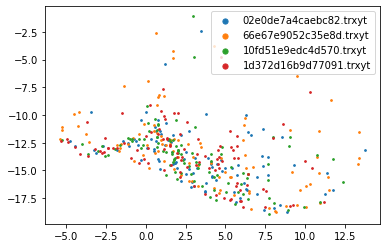

In [21]:
# Visualize latent vectors
for ts in tss:
    U = ts.locs.groupby("n")[["U_1","U_2"]].mean().sample(100).values
    plt.scatter(U[:,0],U[:,1],label=os.path.split(ts.origin_file)[1],s=3)
plt.legend(markerscale=3)

# MMD inter units

In [22]:
RUN_NAME = "example"

mmd = MMDInterUnitAnalysis(track_sets=tss,
    unit_key=["file"], 
    # it is possible to delimit units by a column of the trajectories files (if they have additional information)
    # or to consider a cartesian product of two columns. 
    # example of valid values : ["file","time_bin"], ["file","organelle"], ["organelle"] (spanned across files)
    use_high_dimension=False,
    locs_cols_to_keep = ["D","log_D","length","alpha","best_model","distance"],
    n_bootstraps=250,
    n_max_trajs_per_unit=500, # For speed, we never consider more than 500 trajectories per unit
    n_min_trajs_per_unit=150, # For accuracy, we discard units with less than 150 trajectories
    run_name=RUN_NAME)

In [23]:
mmd.process()

In [24]:
# Dossier où sont stockés les résultats
# tss.root_folder / MMD_inter_groups / mmd.run_name 
print(mmd.output_path)

/home/tidiane/dev/pasteur/export_folder/MMD_inter_units/example


In [25]:
# fichiers exportés :
glob(os.path.join(mmd.output_path,"*"))

['/home/tidiane/dev/pasteur/export_folder/MMD_inter_units/example/D_bootstrap.zip',
 '/home/tidiane/dev/pasteur/export_folder/MMD_inter_units/example/D_true.zip',
 '/home/tidiane/dev/pasteur/export_folder/MMD_inter_units/example/latent_df.csv',
 '/home/tidiane/dev/pasteur/export_folder/MMD_inter_units/example/units.json',
 '/home/tidiane/dev/pasteur/export_folder/MMD_inter_units/example/p_value.zip']

In [26]:
# Il faut regarder les fonctions "_load()" des différentes classes d'analyses pour voir comment lire les fichiers qu'elles exportent
# par ex :
mmd._p_value

array([[0.        , 0.00438193, 0.00272115, 0.00267338],
       [0.00438193, 0.        , 0.00280341, 0.00180544],
       [0.00272115, 0.00280341, 0.        , 0.00188898],
       [0.00267338, 0.00180544, 0.00188898, 0.        ]])

In [27]:
zarr.load("/home/tidiane/dev/pasteur/export_folder/MMD_inter_units/example/p_value.zip")

array([[0.        , 0.00438193, 0.00272115, 0.00267338],
       [0.00438193, 0.        , 0.00280341, 0.00180544],
       [0.00272115, 0.00280341, 0.        , 0.00188898],
       [0.00267338, 0.00180544, 0.00188898, 0.        ]])

In [28]:
# -> OK, les p-values ont bien été stockées et on peut les lire

In [29]:
mmd.latent_df.columns

Index(['n', 'U_1', 'U_2', 'file', 'arbitrary_condition', 'unit'], dtype='object')

In [30]:
pd.read_csv("/home/tidiane/dev/pasteur/export_folder/MMD_inter_units/example/latent_df.csv")

n       U_1        U_2  \
0        23 -0.793194  10.536502   
1        37 -0.466875  11.856496   
2        52 -0.325172  11.316392   
3       126 -0.386570   3.136104   
4       152 -0.319644   4.835397   
...     ...       ...        ...   
5280  56932 -0.194466   3.954396   
5281  57015 -0.372237  10.356068   
5282  57027 -1.097442   7.514222   
5283  57043  0.576719   2.542661   
5284  57095 -0.271647   4.660399   

                                                   file arbitrary_condition  \
0     /home/tidiane/dev/pasteur/export_folder/02e0de...                   A   
1     /home/tidiane/dev/pasteur/export_folder/02e0de...                   A   
2     /home/tidiane/dev/pasteur/export_folder/02e0de...                   A   
3     /home/tidiane/dev/pasteur/export_folder/02e0de...                   A   
4     /home/tidiane/dev/pasteur/export_folder/02e0de...                   A   
...                                                 ...                 ...   
5280  /home/tidiane/dev/pasteur/export_folder/1d372d...                   B   
5281  /home/tidiane/dev/pasteur/export_folder/1d372d...                   B   
5282  /home/tidiane/dev/pasteur/export_folder/1d372d...                   B   
5283  /home/tidiane/dev/pasteur/export_folder/1d372d...                   B   
5284  /home/tidiane/dev/pasteur/export_folder/1d372d...                   B   

      unit  
0        0  
1        0  
2        0  
3        0  
4        0  
...    ...  
5280     3  
5281     3  
5282     3  
5283     3  
5284     3  

[5285 rows x 6 columns]

In [31]:
# -> C'est OK avec les vecteurs latents aussi

# MDS based on it

In [32]:
mds = MDSAnalysis(track_sets=tss,mmd=mmd,run_name=RUN_NAME)

In [33]:
mds.process()

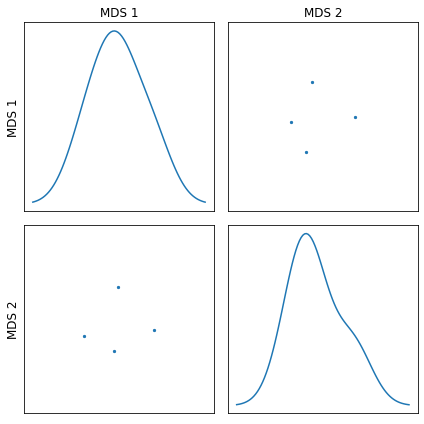

In [34]:
mds.plot_scatter()

In [35]:
# Idem, le dossier suit la même logique
print(mds.output_path)
print(glob(os.path.join(mds.output_path,"*")))

/home/tidiane/dev/pasteur/export_folder/MDS/example
['/home/tidiane/dev/pasteur/export_folder/MDS/example/unit_info.csv']


In [36]:
mds.unit_info

file  unit  \
0  /home/tidiane/dev/pasteur/export_folder/02e0de...     0   
1  /home/tidiane/dev/pasteur/export_folder/66e67e...     1   
2  /home/tidiane/dev/pasteur/export_folder/10fd51...     2   
3  /home/tidiane/dev/pasteur/export_folder/1d372d...     3   

  arbitrary_condition       X_1       X_2  
0                   A  0.034137 -0.002422  
1                   A -0.025086 -0.007144  
2                   B  0.003940  0.032102  
3                   B  0.000124 -0.019445

In [37]:
pd.read_csv("/home/tidiane/dev/pasteur/export_folder/MDS/example/unit_info.csv",index_col=0)

file  unit  \
0  /home/tidiane/dev/pasteur/export_folder/02e0de...     0   
1  /home/tidiane/dev/pasteur/export_folder/66e67e...     1   
2  /home/tidiane/dev/pasteur/export_folder/10fd51...     2   
3  /home/tidiane/dev/pasteur/export_folder/1d372d...     3   

  arbitrary_condition       X_1       X_2  
0                   A  0.034137 -0.002422  
1                   A -0.025086 -0.007144  
2                   B  0.003940  0.032102  
3                   B  0.000124 -0.019445

# MMD inter groups

In [38]:
mmd = MMDInterGroupAnalysis(track_sets=tss,
    unit_key=["file"],
    null_mode="mix",
    group_by_keys=["arbitrary_condition"],
    # it is possible to delimit units by a column of the trajectories files (if they have additional information)
    # or to consider a cartesian product of two columns. 
    # example of valid values : ["file","time_bin"], ["file","organelle"], ["organelle"] (spanned across files)
    use_high_dimension=False,
    n_max_bootstraps=250,
    n_max_trajs_per_unit=500, # For speed, we never consider more than 500 trajectories per unit
    n_min_trajs_per_unit=150, # For accuracy, we discard units with less than 150 trajectories
    run_name=RUN_NAME)

In [39]:
mmd.process(force_recompute=True)

Adding units from tracksets: 100%|██████████| 3/3 [00:00<00:00, 22.05it/s, 1468 trajs from /home/tidiane/dev/pasteur/export_folder/1d372d16b9d77091.trxyt]


latent_df has 3 units


  0%|          | 0/1 [00:00<?, ?it/s]

# units 
	 A : 2
	 B : 1
min_n = 595 (1468, 595)
# of trajs : 1000 vs 500


(250 bootstraps) : {'arbitrary_condition': 'A'} VS {'arbitrary_condition': 'B'}: 100%|██████████| 1/1 [00:18<00:00, 18.77s/it]


In [64]:
comps = mmd.comparisons
groups = mmd._groups
comp_matrix = np.ndarray((len(groups),len(groups)),dtype=str ).tolist()# dtype = str)
for c in comps: 
    c0 = groups.index(c[0])
    c1 = groups.index(c[1])
    print(c0,c1,c[0],c[1])
    comp_matrix[c0][c1] = str(c[0]) + ' ' + str(c[1])
    comp_matrix[c1][c0] = str(c[0]) + ' ' + str(c[1])

0 1 {'arbitrary_condition': 'A'} {'arbitrary_condition': 'B'}


In [53]:
groups

[{'arbitrary_condition': 'A'}, {'arbitrary_condition': 'B'}]

In [65]:
comp_matrix

[['', "{'arbitrary_condition': 'A'} {'arbitrary_condition': 'B'}"],
 ["{'arbitrary_condition': 'A'} {'arbitrary_condition': 'B'}", '']]

In [41]:
from palm_tools.analysis.analysis_tools.mmd import witness_function
comps = mmd.comparisons
c = comps[0]

H1 = mmd.sample_latent_vecs_for_cond(c[0])
H2 = mmd.sample_latent_vecs_for_cond(c[1])
xx, yy, w, w1, w2 = witness_function(H1.values, H2.values, lims=None)
n = xx.shape[0]
m = xx.shape[1]
trajs_list = []
for i in range(n):
    tl = []
    for j in range(m):
        point = np.array([xx[i, j], yy[i, j]])
        trajs = mmd.find_closest_trajectories(
            latent_pos=point, n_trajs=1
        )
        tl.append(np.transpose(trajs[0]).tolist())
    trajs_list.append(tl)

In [42]:
trajs_list[0][0]

[[2.908896685765524,
  2.906739985767225,
  2.902986023848944,
  2.9062285466827613,
  2.7783603589669714,
  2.7021329735543365,
  2.6884579878411854],
 [6.94358256421218,
  6.931380871563343,
  6.925971058313034,
  6.9425946433822965,
  6.965593646536962,
  7.036461569537629,
  7.012187211061712]]

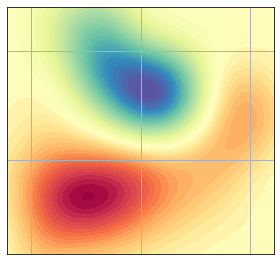

In [ ]:
mmd.plot_witness_function({"arbitrary_condition":"A"},{"arbitrary_condition":"B"})

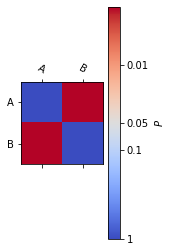

In [ ]:
mmd.plot_mosaic()

/home/tidiane/dev/pasteur/palm-tools-master/src/palm_tools/analysis/mmd_analysis.py:552: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_values("distance", inplace=True)
/home/tidiane/dev/pasteur/palm-tools-master/src/palm_tools/analysis/mmd_analysis.py:868: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


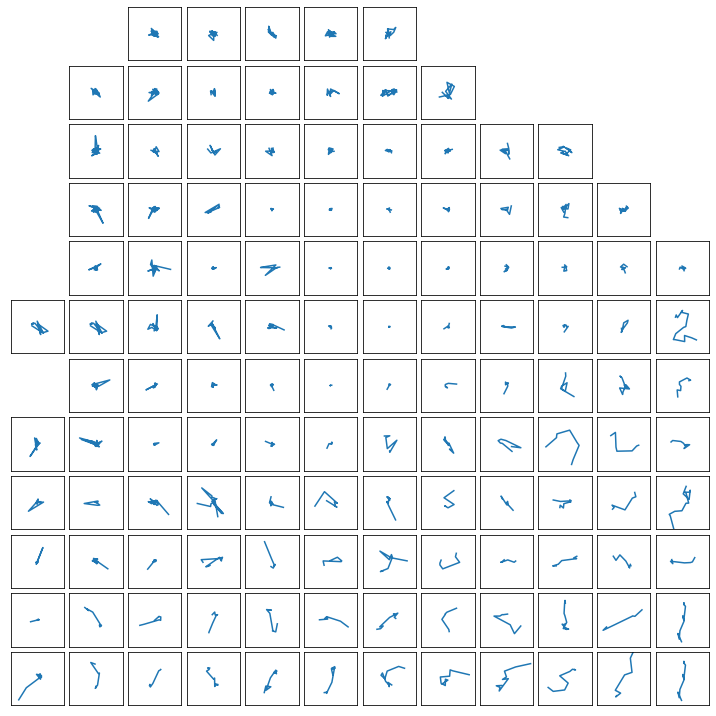

In [ ]:
mmd.plot_latent_map()

Interpolations are done
Looking at critical trajectories


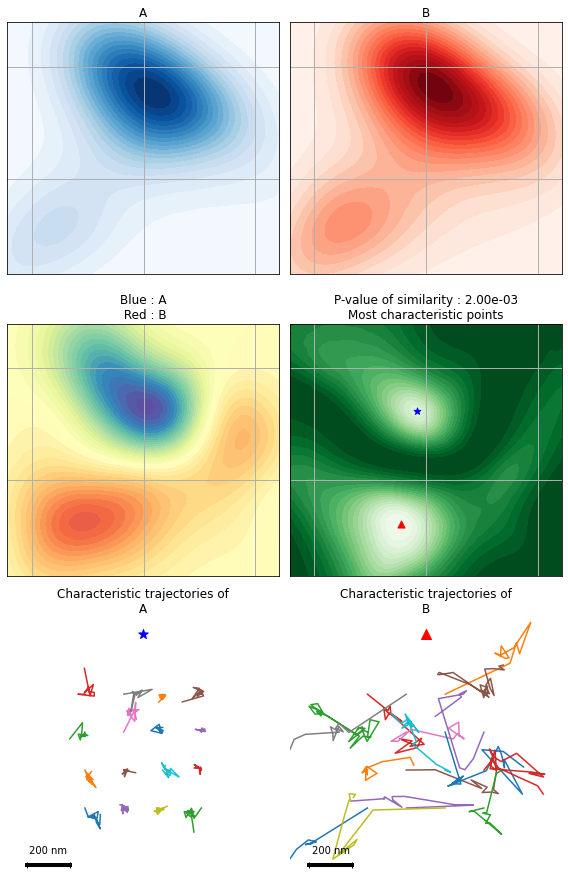

In [ ]:
mmd.plot_discriminant_trajs({"arbitrary_condition":"A"},{"arbitrary_condition":"B"})